# Project 2 – Group 34
## Dataset: Heart Failure Clinical Records
**Source:** [UCI Machine Learning Repository](https://doi.org/10.24432/C5Z89R)
 
> This dataset contains the medical records of 299 patients who experienced heart failure, collected during their follow-up period. Each patient profile includes 13 clinical features.


Loading and cleaning the dataset from the outcome of hand_in 1:

In [7]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# transformationer
def identity(x): return x
def log(x): return np.log(x + 1e-6)   # undgå log(0)
def sqrt(x): return np.sqrt(np.clip(x, 0, None))  # sqrt kræver >=0
def cbrt(x): return np.cbrt(x)        # kan håndtere negative
def reciprocal(x): return 1.0 / (x + 1e-6)  # undgå /0

# Load Heart Failure Clinical Records Dataset
df = pd.read_csv('../02452_Group34_Project1/data/heart_failure_clinical_records_dataset.csv')

## Regression: 

[none] λ* median=152 | mean outer=5670.3202 | baseline CV=6027.4238 | w0=130.2609
[log_cpk] λ* median=163 | mean outer=5642.0846 | baseline CV=6027.4238 | w0=130.2609
[sqrt_platelets] λ* median=152 | mean outer=5671.3802 | baseline CV=6027.4238 | w0=130.2609
[recip_crea] λ* median=142 | mean outer=5653.9347 | baseline CV=6027.4238 | w0=130.2609


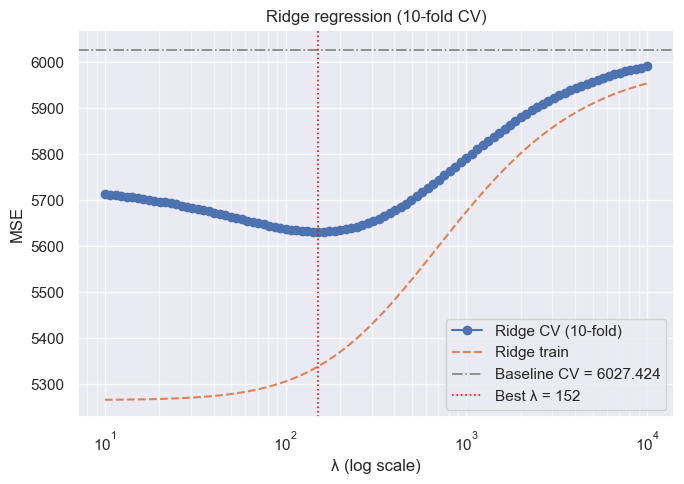

[all_three] λ* median=152 | mean outer=5631.2920 | baseline CV=6027.4238 | w0=130.2609

=== Coefficient comparison (all models + deltas, intercept included) ===
                                   none   log_cpk  sqrt_platelets  recip_crea  \
Feature                                                                         
Intercept (w0)                 130.2609  130.2609        130.2609    130.2609   
num__high_blood_pressure        -9.6523   -9.2071         -9.6238    -10.2139   
num__age                        -9.9013   -9.4585         -9.9170     -9.5713   
num__anaemia                    -6.8430   -5.9941         -6.8581     -7.2323   
num__serum_creatinine           -5.9667   -5.8049         -5.9801      6.5251   
num__serum_sodium                3.7702    3.5319          3.7869      3.6235   
num__creatinine_phosphokinase   -2.4493    2.8921         -2.4392     -2.7700   
num__ejection_fraction           2.1686    2.2984          2.1912      1.6732   
num__smoking                 

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def run_ridge(df, target="time", metric="mse", lambdas=None, k_outer=10, k_inner=None,
              drop_extra=None, random_state=42, plot=True):
    """Ridge regression with optional nested CV — all numeric features standardized."""
    if lambdas is None:
        lambdas = np.logspace(-4, 4, 50)

    drop = [target] + (drop_extra or [])
    y = df[target].values
    X = df.drop(columns=drop, errors="ignore").copy()

    # --- all numeric standardized ---
    num = X.select_dtypes(include=[np.number]).columns
    pre = ColumnTransformer([("num", StandardScaler(), num)], remainder="drop")

    ridge = Pipeline([("pre", pre), ("m", Ridge(random_state=0))])
    base  = Pipeline([("pre", pre), ("m", DummyRegressor(strategy="mean"))])

    def m(y_t, y_p):
        if metric == "mae": return mean_absolute_error(y_t, y_p)
        if metric == "r2":  return r2_score(y_t, y_p)
        return mean_squared_error(y_t, y_p)

    hi = (metric == "r2")
    kf_outer = KFold(k_outer, shuffle=True, random_state=random_state)

    outer_scores, best_lambdas = [], []

    # ---------- SINGLE-CV MODE: build curves & global best ----------
    if k_inner is None:
        tr_curve, va_curve = [], []
        for l in lambdas:
            tr_f, va_f = [], []
            for tr_idx, va_idx in kf_outer.split(X):
                Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
                ytr, yva = y[tr_idx], y[va_idx]
                ridge.set_params(m__alpha=l).fit(Xtr, ytr)
                tr_f.append(m(ytr, ridge.predict(Xtr)))
                va_f.append(m(yva, ridge.predict(Xva)))
            tr_curve.append(np.mean(tr_f))
            va_curve.append(np.mean(va_f))
        tr_curve, va_curve = np.array(tr_curve), np.array(va_curve)
        best_global = lambdas[np.argmax(va_curve) if hi else np.argmin(va_curve)]
    # ----------------------------------------------------------------

    for train_idx, test_idx in kf_outer.split(X):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        if k_inner:  # nested CV: choose λ* on the training split
            kf_inner = KFold(k_inner, shuffle=True, random_state=random_state)
            inner_val = []
            for l in lambdas:
                fold_scores = []
                for i_tr, i_va in kf_inner.split(Xtr):
                    Xtr2, Xva2 = Xtr.iloc[i_tr], Xtr.iloc[i_va]
                    ytr2, yva2 = ytr[i_tr], ytr[i_va]
                    ridge.set_params(m__alpha=l).fit(Xtr2, ytr2)
                    fold_scores.append(m(yva2, ridge.predict(Xva2)))
                inner_val.append(np.mean(fold_scores))
            best = lambdas[np.argmax(inner_val) if hi else np.argmin(inner_val)]
        else:
            best = best_global  # reuse global best in single-CV mode

        ridge.set_params(m__alpha=best).fit(Xtr, ytr)
        outer_scores.append(m(yte, ridge.predict(Xte)))
        best_lambdas.append(best)

    mean_outer = float(np.mean(outer_scores))

    # --- baseline (same outer folds) ---
    bt, bv = [], []
    for i_tr, i_va in kf_outer.split(X):
        Xtr, Xva = X.iloc[i_tr], X.iloc[i_va]
        ytr, yva = y[i_tr], y[i_va]
        base.fit(Xtr, ytr)
        bt.append(m(ytr, base.predict(Xtr)))
        bv.append(m(yva, base.predict(Xva)))
    b_tr, b_va = float(np.mean(bt)), float(np.mean(bv))

    # --- plot (only in single-CV mode when we have curves) ---
    # --- plot (only in single-CV mode when we have curves) ---
    if plot and k_inner is None:
        plt.figure(figsize=(7, 5))
        plt.semilogx(lambdas, va_curve, 'o-', label=f"Ridge CV ({k_outer}-fold)")
        plt.semilogx(lambdas, tr_curve, '--', label="Ridge train")
        plt.axhline(b_va, color='gray', ls='-.', lw=1.2, label=f"Baseline CV = {b_va:.3f}")
        plt.axvline(best_global, color='red', ls=':', lw=1.2, label=f"Best λ = {best_global:.3g}")

        plt.xlabel("λ (log scale)")
        plt.ylabel(metric.upper())
        plt.title(f"Ridge regression ({k_outer}-fold CV)")
        
        # nice grid with both major and minor lines
        ax = plt.gca()
        ax.set_axisbelow(True)
        ax.grid(True, which="major",  alpha=0.8)
        ax.grid(True, which="minor",  alpha=0.6)
        
        # ensure baseline line is within visible limits
        ymin, ymax = ax.get_ylim()
        buffer = 0.05 * (ymax - ymin)
        plt.ylim(min(ymin, b_va - buffer), max(ymax, b_va + buffer))
        
        plt.legend()
        plt.tight_layout()
        plt.show()


    # --- final fit & coefficients (use median λ* across outer folds) ---
    ridge.set_params(m__alpha=float(np.median(best_lambdas))).fit(X, y)

    # feature names + weights + intercept
    feat_names = ridge.named_steps["pre"].get_feature_names_out().tolist()
    w = ridge.named_steps["m"].coef_
    w0 = float(ridge.named_steps["m"].intercept_)

    coefs = pd.DataFrame({"Feature": feat_names, "Coef": w}) \
            .sort_values(by="Coef", key=lambda s: s.abs(), ascending=False) \
            .reset_index(drop=True)

    # include intercept as first row for convenience
    coefs_with_w0 = pd.concat([
        pd.DataFrame([{"Feature": "Intercept (w0)", "Coef": w0}]),
        pd.DataFrame({"Feature": feat_names, "Coef": w})
    ], ignore_index=True)

    return {
        "outer_cv": int(k_outer),
        "inner_cv": int(k_inner) if k_inner else None,
        "mean_outer_score": mean_outer,
        "best_lambdas": list(best_lambdas),
        "baseline_train": b_tr,
        "baseline_cv": b_va,
        "intercept": w0,
        "coefs": coefs,                 # sorted by |w| (no intercept)
        "coefs_with_w0": coefs_with_w0, # includes intercept row
        "features_used": feat_names ,
        "model": ridge
    }

# ===== schemes & run loop =====
schemes = [
    ("none",          [0,0,0]),
    ("log_cpk",       [1,0,0]),
    ("sqrt_platelets",[0,1,0]),
    ("recip_crea",    [0,0,1]),
    ("all_three",     [1,1,1]),
]

results = {}
for name, scheme in schemes:
    X_transformed = df.copy()
    if scheme[0] == 1 and "creatinine_phosphokinase" in X_transformed:
        X_transformed['creatinine_phosphokinase'] = log(X_transformed['creatinine_phosphokinase'])
    if scheme[1] == 1 and "platelets" in X_transformed:
        X_transformed['platelets'] = sqrt(X_transformed['platelets'])
    if scheme[2] == 1 and "serum_creatinine" in X_transformed:
        X_transformed['serum_creatinine'] = reciprocal(X_transformed['serum_creatinine'])
    # --- only show plot for 'all_three' scheme ---
    show_plot = (scheme == [1, 1, 1])
    res = run_ridge(
        X_transformed, target="time", metric="mse",
        lambdas=np.logspace(1,4,100),
        k_outer=10,                   # set k_inner=3 if you want nested CV per scheme
        drop_extra=['DEATH_EVENT'],
        random_state=42, plot=show_plot 
    )
    results[name] = res
    print(f"[{name}] λ* median={np.median(res['best_lambdas']):.3g} | mean outer={res['mean_outer_score']:.4f} | baseline CV={res['baseline_cv']:.4f} | w0={res['intercept']:.4f}")

# ===== merge coefficients (with intercept row) =====
def coef_series_with_w0(runres, label):
    s = runres["coefs_with_w0"].set_index("Feature")["Coef"]
    s.name = label
    return s

coef_tab = pd.concat([coef_series_with_w0(results[name], name) for name, _ in schemes],
                     axis=1, join="outer").fillna(0.0)

# add Δ-columns vs baseline (none)
for name, _ in schemes:
    if name == "none": continue
    coef_tab[f"Δ_{name}"] = coef_tab[name] - coef_tab["none"]

# order rows by absolute size in 'all_three' (if present), otherwise by 'none'
sort_key = "all_three" if "all_three" in coef_tab.columns else "none"
coef_tab = coef_tab.reindex(coef_tab[sort_key].abs().sort_values(ascending=False).index)

# show: all model coefficients first, then deltas
coef_cols  = [name for name, _ in schemes]                 # ['none','log_cpk',...]
delta_cols = [f"Δ_{name}" for name, _ in schemes if name != "none"]
view_cols  = coef_cols + delta_cols

print("\n=== Coefficient comparison (all models + deltas, intercept included) ===")
print(coef_tab.loc[:, view_cols].round(4))

ridge_model = results["all_three"]["model"]
reg = ridge_model.named_steps['m']

# Either specify manually or choose random
specific_indices = [42, 51, 213] 
n_random = 5                     
use_random = False 

if use_random:
    np.random.seed(42)
    specific_indices = np.random.choice(len(df), n_random, replace=False)

print("=== Example predictions for selected patients ===\n")

for i in specific_indices:
    # Extract and reshape input
    x_i = X[i].copy().reshape(1, -1)
    y_true = df.loc[i, "time"]

    # Manual prediction (same as ridge.predict)
    y_pred = reg.intercept_ + np.dot(reg.coef_.reshape(1, -1), x_i.T)
    y_pred_pipe = reg.predict(x_i)[0]

    print(f"Patient index:            {i}")
    print(f"True follow-up time:      {y_true:.1f} days")
    print(f"Predicted (manual calc):  {y_pred.item():.1f} days")
    print(f"Predicted (pipeline):     {y_pred_pipe:.1f} days")
    print(f"Prediction error:         {y_pred_pipe - y_true:.1f} days")
    print(f"Deviation from mean pred: {y_pred_pipe - reg.intercept_:.1f} days")
    print("-" * 50)

# ===== Example patient 42 =====
i = 42

feat_names = results["all_three"]["features_used"]

print(f"\n=== Example patient {i} feature values ===\n")
for name, w, x in zip(feat_names, reg.coef_, X[i]):
    print(f"{name:25s}:  (w = {w:8.3f})   (x = {x:8.3f})   (w*x = {w*x:8.3f})")

sum_contrib = np.dot(reg.coef_, X[i])
y_pred = reg.intercept_ + sum_contrib

print("\n--- Totals ---")
print(f"{'Sum of w_j*x_j':25s}: {sum_contrib:8.3f}")
print(X[42])

=== Example predictions for selected patients ===

Patient index:            42
True follow-up time:      33.0 days
Predicted (manual calc):  117.9 days
Predicted (pipeline):     117.9 days
Prediction error:         84.9 days
Deviation from mean pred: -12.3 days
--------------------------------------------------
Patient index:            51
True follow-up time:      43.0 days
Predicted (manual calc):  108.5 days
Predicted (pipeline):     108.5 days
Prediction error:         65.5 days
Deviation from mean pred: -21.8 days
--------------------------------------------------
Patient index:            213
True follow-up time:      193.0 days
Predicted (manual calc):  109.3 days
Predicted (pipeline):     109.3 days
Prediction error:         -83.7 days
Deviation from mean pred: -21.0 days
--------------------------------------------------

=== Example patient 42 feature values ===

num__age                 :  (w =   -9.189)   (x =    0.772)   (w*x =   -7.093)
num__anaemia             :  (w =  

### Regression - Part B
We are to solve a regression problem by comparing three different models: a baseline (mean), regularized linear regression, and an artifical neural network (ANN).

In [25]:
# Data for regression models
X # transformed already above
y = df['time'].values

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

# Outer and inner cross-validation folds
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grids for models
ridge_param_grid = {'lambda': [0, 100, 120, 150, 190, 240, 300]}
ann_param_grid = {'h': [1, 2, 3, 4, 5]}

# Store results
results_list = []
ttest_results = []
y_true_outer, y_pred_ridge_outer, y_pred_ann_outer = [], [], []

# Outer cross-validation loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Baseline Model ---
    baseline = np.mean(y_train)
    y_pred_baseline = np.full_like(y_test, baseline)
    E_baseline = mean_squared_error(y_test, y_pred_baseline)

    # --- Ridge Regression: Manual Inner CV for Best Lambda ---
    ridge_val_errors = {}
    for lambda_val in ridge_param_grid['lambda']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            model = Ridge(alpha=lambda_val)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(mean_squared_error(y_inner_val, y_pred_val))
        ridge_val_errors[lambda_val] = np.mean(inner_errors)
    best_lambda = min(ridge_val_errors, key=ridge_val_errors.get)

    # Train final Ridge model on outer train set with best lambda
    final_ridge = Ridge(alpha=best_lambda)
    final_ridge.fit(X_train, y_train)
    y_pred_ridge = final_ridge.predict(X_test)
    E_ridge = mean_squared_error(y_test, y_pred_ridge)

    # --- ANN: Manual Inner CV for Best h ---
    ann_val_errors = {}
    for h_val in ann_param_grid['h']:
        inner_errors = []
        for idx, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train, y_train)):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            model = MLPRegressor(hidden_layer_sizes=(h_val,), solver='sgd', max_iter=3000, random_state=0,learning_rate_init=0.002)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(mean_squared_error(y_inner_val, y_pred_val))
        ann_val_errors[h_val] = np.mean(inner_errors)
    best_h = min(ann_val_errors, key=ann_val_errors.get)

    # Train final ANN model on outer train set with best h
    final_ann = MLPRegressor(hidden_layer_sizes=(best_h,), solver='sgd', max_iter=10000, random_state=42)
    final_ann.fit(X_train, y_train)
    y_pred_ann = final_ann.predict(X_test)
    E_ann = mean_squared_error(y_test, y_pred_ann)

    # Append 2-Level CV results for this fold
    results_list.append([fold, best_h, E_ann, best_lambda, E_ridge, E_baseline])
    
    # Store predictions for statistical analysis
    y_true_outer.extend(y_test)
    y_pred_ridge_outer.extend(y_pred_ridge)
    y_pred_ann_outer.extend(y_pred_ann)

# Create a DataFrame for the results
results_df = pd.DataFrame(results_list, columns=['Outer Fold', 'Best h', 'ANN Error', 'Best lambda', 'Ridge Error', 'Baseline Error'])
print(results_df)
ttest_results_df = pd.DataFrame(ttest_results, columns=['Outer Fold','CI base VS ridge','p-value base VS ridge','CI base VS ann','p-value base VS ann','CI ridge VS ann','p-value ridge VS ann'])
print(ttest_results_df)

# Determine the most frequently chosen parameters from the cross-validation
best_lambda_overall = results_df['Best lambda'].mode()[0]
best_h_overall = results_df['Best h'].mode()[0]


results_df['ANN Error'] = results_df['ANN Error'].map('{:.0f}'.format)
results_df['Ridge Error'] = results_df['Ridge Error'].map('{:.0f}'.format)
results_df['Baseline Error'] = results_df['Baseline Error'].map('{:.0f}'.format)
results_df['Best lambda'] = results_df['Best lambda'].map(lambda x: f"{x:g}")  # scientific if needed

latex_table = r"""
\begin{table}[ht]
\centering

\begin{tabular}{cccccc}
\toprule
\multirow{Outer fold $i$} & 
\multicolumn{2}{c}{ANN} & 
\multicolumn{2}{c}{Linear regression} & 
\multirow{baseline} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
 & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$\\
\midrule
"""
# Loop through rows and append formatted LaTeX lines
for _, row in results_df.iterrows():
    latex_table += f"{int(row['Outer Fold'])} & {row['Best h']} & {row['ANN Error']} & {row['Best lambda']} & {row['Ridge Error']} & {row['Baseline Error']} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\caption{Two-level cross-validation results comparing ANN, Ridge regression, and baseline.}
\label{tab:regression_partB2}
\end{table}
"""

print(latex_table)



   Outer Fold  Best h    ANN Error  Best lambda  Ridge Error  Baseline Error
0           1       1  5322.994486          190  5272.636952     5538.500000
1           2       4  6098.514709          190  5301.904885     5581.866667
2           3       2  5774.432651          190  5664.506426     6384.733333
3           4       1  3433.845746          240  3897.727540     5103.333333
4           5       2  3957.334987          190  4096.818203     4708.466667
5           6       2  7293.484684          120  6086.010180     6819.933333
6           7       2  6109.654450          190  6337.075135     7013.833333
7           8       2  7195.155009          120  8103.521088     7352.133333
8           9       2  6893.807505          190  6405.821617     5964.633333
9          10       2  5803.374654          120  5387.680075     5822.275862
Empty DataFrame
Columns: [Outer Fold, CI base VS ridge, p-value base VS ridge, CI base VS ann, p-value base VS ann, CI ridge VS ann, p-value ridge VS ann

#### 3. Pairwise comparison using method 11.3.4

In [38]:
# Pairwise statistical analysis using method 11.3.4 from the book (page 215)
def method_11_3_4(y_true, y_pred_model1, y_pred_model2, alpha=0.05):
    from scipy.stats import t
    n = len(y_true)
    errors_model1 = (y_true - y_pred_model1) ** 2
    errors_model2 = (y_true - y_pred_model2) ** 2
    z_i = errors_model1 - errors_model2
    z_hat = np.mean(z_i)
    sigma_sq_tilde = np.sum((z_i - z_hat)**2) / (n * (n - 1))
    sigma_tilde = np.sqrt(sigma_sq_tilde)
    # Calculate confidence interval
    # See bottom of page 211 for explanation of the t-distribution usage
    v = n - 1 # degrees of freedom
    z_L = z_hat + sigma_tilde * t.ppf(alpha/2, v)
    z_U = z_hat + sigma_tilde * t.ppf(1 - alpha/2, v)
    # Calculate p-value
    p = 2 * t.cdf(-abs(z_hat), v, loc=0, scale=sigma_tilde)
    return z_hat, (z_L, z_U), p


# Cross validation folds for method 11.3.4
cv_folds = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation loop for method 11.3.4
y_pred_baseline_all, y_pred_ridge_all, y_pred_ann_all, y_test_all = [], [], [], []
for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
   # --- Baseline Model ---
    baseline = np.mean(y_train)
    y_pred_baseline = np.full_like(y_test, baseline)

    # --- Ridge Regression ---
    model = Ridge(alpha=lambda_val)
    model.fit(X_train, y_train)
    y_pred_ridge = model.predict(X_test)

    # --- ANN ---
    model = MLPRegressor(hidden_layer_sizes=(h_val,), solver='sgd', max_iter=10000, random_state=0,learning_rate_init=0.002)
    model.fit(X_train, y_train)
    y_pred_ann = model.predict(X_test)

    # Store predictions and true values for later analysis
    y_pred_baseline_all.extend(y_pred_baseline)
    y_pred_ridge_all.extend(y_pred_ridge)
    y_pred_ann_all.extend(y_pred_ann)
    y_test_all.extend(y_test)

# Convert lists to numpy arrays for easier manipulation
y_pred_baseline_all = np.array(y_pred_baseline_all)
y_pred_ridge_all = np.array(y_pred_ridge_all)
y_pred_ann_all = np.array(y_pred_ann_all)
y_test_all = np.array(y_test_all)

# Paired t-test pairwise between models
# Baseline vs Ridge
z_hat_baseline_ridge, CI_baseline_ridge, p_baseline_ridge = method_11_3_4(y_test_all, y_pred_baseline_all, y_pred_ridge_all)
# Baseline vs ANN
z_hat_baseline_ann, CI_baseline_ann, p_baseline_ann = method_11_3_4(y_test_all, y_pred_baseline_all, y_pred_ann_all)
# Ridge vs ANN
z_hat_ridge_ann, CI_ridge_ann, p_ridge_ann = method_11_3_4(y_test_all, y_pred_ridge_all, y_pred_ann_all)



# Generate latex table using ChatGPT
results = {
    "Model Comparison": [
        "Baseline vs Ridge",
        "Baseline vs ANN",
        "Ridge vs ANN"
    ],
    "z_hat": [
        f"{z_hat_baseline_ridge:.1f}",
        f"{z_hat_baseline_ann:.1f}",
        f"{z_hat_ridge_ann:.1f}"
    ],
    "Confidence Interval": [
        f"[{CI_baseline_ridge[0]:.0f}, {CI_baseline_ridge[1]:.0f}]",
        f"[{CI_baseline_ann[0]:.0f}, {CI_baseline_ann[1]:.0f}]",
        f"[{CI_ridge_ann[0]:.0f}, {CI_ridge_ann[1]:.0f}]"
    ],
    "p-value": [
        f"{p_baseline_ridge:.5f}",
        f"{p_baseline_ann:.5f}",
        f"{p_ridge_ann:.5f}"
    ]
}

# Convert to DataFrame for convenience
latex_df = pd.DataFrame(results)

# Generate LaTeX table code
latex_code = latex_df.to_latex(
    index=False,
    escape=False,     # allow [a,b] in CI
    float_format="%.4f",
    column_format="lccc",
    bold_rows=False,
    longtable=False,
    caption="Pairwise model comparison using method 11.3.4 (paired t-test).",
    label="tab:pairwise_ttest"
).replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
print(latex_code)




\begin{table}
\caption{Pairwise model comparison using method 11.3.4 (paired t-test).}
\label{tab:pairwise_ttest}
\begin{tabular}{lccc}
\toprule
Model Comparison & z_hat & Confidence Interval & p-value \\
\midrule
Baseline vs Ridge & 374.7 & [121, 628] & 0.00392 \\
Baseline vs ANN & -495.0 & [-1225, 235] & 0.18278 \\
Ridge vs ANN & -869.7 & [-1511, -228] & 0.00804 \\
\bottomrule
\end{tabular}
\end{table}



### Regression - Part B
We are to solve a regression problem by comparing three different models: a baseline (mean), regularized linear regression, and an artifical neural network (ANN).

In [25]:
# Data for regression models
X # transformed already above
y = df['time'].values

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

# Outer and inner cross-validation folds
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grids for models
ridge_param_grid = {'lambda': [0, 100, 120, 150, 190, 240, 300]}
ann_param_grid = {'h': [1, 2, 3, 4, 5]}

# Store results
results_list = []
ttest_results = []
y_true_outer, y_pred_ridge_outer, y_pred_ann_outer = [], [], []

# Outer cross-validation loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Baseline Model ---
    baseline = np.mean(y_train)
    y_pred_baseline = np.full_like(y_test, baseline)
    E_baseline = mean_squared_error(y_test, y_pred_baseline)

    # --- Ridge Regression: Manual Inner CV for Best Lambda ---
    ridge_val_errors = {}
    for lambda_val in ridge_param_grid['lambda']:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            model = Ridge(alpha=lambda_val)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(mean_squared_error(y_inner_val, y_pred_val))
        ridge_val_errors[lambda_val] = np.mean(inner_errors)
    best_lambda = min(ridge_val_errors, key=ridge_val_errors.get)

    # Train final Ridge model on outer train set with best lambda
    final_ridge = Ridge(alpha=best_lambda)
    final_ridge.fit(X_train, y_train)
    y_pred_ridge = final_ridge.predict(X_test)
    E_ridge = mean_squared_error(y_test, y_pred_ridge)

    # --- ANN: Manual Inner CV for Best h ---
    ann_val_errors = {}
    for h_val in ann_param_grid['h']:
        inner_errors = []
        for idx, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train, y_train)):
            X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

            model = MLPRegressor(hidden_layer_sizes=(h_val,), solver='sgd', max_iter=3000, random_state=0,learning_rate_init=0.002)
            model.fit(X_inner_train, y_inner_train)
            y_pred_val = model.predict(X_inner_val)
            inner_errors.append(mean_squared_error(y_inner_val, y_pred_val))
        ann_val_errors[h_val] = np.mean(inner_errors)
    best_h = min(ann_val_errors, key=ann_val_errors.get)

    # Train final ANN model on outer train set with best h
    final_ann = MLPRegressor(hidden_layer_sizes=(best_h,), solver='sgd', max_iter=10000, random_state=42)
    final_ann.fit(X_train, y_train)
    y_pred_ann = final_ann.predict(X_test)
    E_ann = mean_squared_error(y_test, y_pred_ann)

    # Append 2-Level CV results for this fold
    results_list.append([fold, best_h, E_ann, best_lambda, E_ridge, E_baseline])
    
    # Store predictions for statistical analysis
    y_true_outer.extend(y_test)
    y_pred_ridge_outer.extend(y_pred_ridge)
    y_pred_ann_outer.extend(y_pred_ann)

# Create a DataFrame for the results
results_df = pd.DataFrame(results_list, columns=['Outer Fold', 'Best h', 'ANN Error', 'Best lambda', 'Ridge Error', 'Baseline Error'])
print(results_df)
ttest_results_df = pd.DataFrame(ttest_results, columns=['Outer Fold','CI base VS ridge','p-value base VS ridge','CI base VS ann','p-value base VS ann','CI ridge VS ann','p-value ridge VS ann'])
print(ttest_results_df)

# Determine the most frequently chosen parameters from the cross-validation
best_lambda_overall = results_df['Best lambda'].mode()[0]
best_h_overall = results_df['Best h'].mode()[0]


results_df['ANN Error'] = results_df['ANN Error'].map('{:.0f}'.format)
results_df['Ridge Error'] = results_df['Ridge Error'].map('{:.0f}'.format)
results_df['Baseline Error'] = results_df['Baseline Error'].map('{:.0f}'.format)
results_df['Best lambda'] = results_df['Best lambda'].map(lambda x: f"{x:g}")  # scientific if needed

latex_table = r"""
\begin{table}[ht]
\centering

\begin{tabular}{cccccc}
\toprule
\multirow{Outer fold $i$} & 
\multicolumn{2}{c}{ANN} & 
\multicolumn{2}{c}{Linear regression} & 
\multirow{baseline} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
 & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$\\
\midrule
"""
# Loop through rows and append formatted LaTeX lines
for _, row in results_df.iterrows():
    latex_table += f"{int(row['Outer Fold'])} & {row['Best h']} & {row['ANN Error']} & {row['Best lambda']} & {row['Ridge Error']} & {row['Baseline Error']} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\caption{Two-level cross-validation results comparing ANN, Ridge regression, and baseline.}
\label{tab:regression_partB2}
\end{table}
"""

print(latex_table)



   Outer Fold  Best h    ANN Error  Best lambda  Ridge Error  Baseline Error
0           1       1  5322.994486          190  5272.636952     5538.500000
1           2       4  6098.514709          190  5301.904885     5581.866667
2           3       2  5774.432651          190  5664.506426     6384.733333
3           4       1  3433.845746          240  3897.727540     5103.333333
4           5       2  3957.334987          190  4096.818203     4708.466667
5           6       2  7293.484684          120  6086.010180     6819.933333
6           7       2  6109.654450          190  6337.075135     7013.833333
7           8       2  7195.155009          120  8103.521088     7352.133333
8           9       2  6893.807505          190  6405.821617     5964.633333
9          10       2  5803.374654          120  5387.680075     5822.275862
Empty DataFrame
Columns: [Outer Fold, CI base VS ridge, p-value base VS ridge, CI base VS ann, p-value base VS ann, CI ridge VS ann, p-value ridge VS ann

#### 3. Pairwise comparison using method 11.3.4

In [38]:
# Pairwise statistical analysis using method 11.3.4 from the book (page 215)
def method_11_3_4(y_true, y_pred_model1, y_pred_model2, alpha=0.05):
    from scipy.stats import t
    n = len(y_true)
    errors_model1 = (y_true - y_pred_model1) ** 2
    errors_model2 = (y_true - y_pred_model2) ** 2
    z_i = errors_model1 - errors_model2
    z_hat = np.mean(z_i)
    sigma_sq_tilde = np.sum((z_i - z_hat)**2) / (n * (n - 1))
    sigma_tilde = np.sqrt(sigma_sq_tilde)
    # Calculate confidence interval
    # See bottom of page 211 for explanation of the t-distribution usage
    v = n - 1 # degrees of freedom
    z_L = z_hat + sigma_tilde * t.ppf(alpha/2, v)
    z_U = z_hat + sigma_tilde * t.ppf(1 - alpha/2, v)
    # Calculate p-value
    p = 2 * t.cdf(-abs(z_hat), v, loc=0, scale=sigma_tilde)
    return z_hat, (z_L, z_U), p


# Cross validation folds for method 11.3.4
cv_folds = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation loop for method 11.3.4
y_pred_baseline_all, y_pred_ridge_all, y_pred_ann_all, y_test_all = [], [], [], []
for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
   # --- Baseline Model ---
    baseline = np.mean(y_train)
    y_pred_baseline = np.full_like(y_test, baseline)

    # --- Ridge Regression ---
    model = Ridge(alpha=lambda_val)
    model.fit(X_train, y_train)
    y_pred_ridge = model.predict(X_test)

    # --- ANN ---
    model = MLPRegressor(hidden_layer_sizes=(h_val,), solver='sgd', max_iter=10000, random_state=0,learning_rate_init=0.002)
    model.fit(X_train, y_train)
    y_pred_ann = model.predict(X_test)

    # Store predictions and true values for later analysis
    y_pred_baseline_all.extend(y_pred_baseline)
    y_pred_ridge_all.extend(y_pred_ridge)
    y_pred_ann_all.extend(y_pred_ann)
    y_test_all.extend(y_test)

# Convert lists to numpy arrays for easier manipulation
y_pred_baseline_all = np.array(y_pred_baseline_all)
y_pred_ridge_all = np.array(y_pred_ridge_all)
y_pred_ann_all = np.array(y_pred_ann_all)
y_test_all = np.array(y_test_all)

# Paired t-test pairwise between models
# Baseline vs Ridge
z_hat_baseline_ridge, CI_baseline_ridge, p_baseline_ridge = method_11_3_4(y_test_all, y_pred_baseline_all, y_pred_ridge_all)
# Baseline vs ANN
z_hat_baseline_ann, CI_baseline_ann, p_baseline_ann = method_11_3_4(y_test_all, y_pred_baseline_all, y_pred_ann_all)
# Ridge vs ANN
z_hat_ridge_ann, CI_ridge_ann, p_ridge_ann = method_11_3_4(y_test_all, y_pred_ridge_all, y_pred_ann_all)



# Generate latex table using ChatGPT
results = {
    "Model Comparison": [
        "Baseline vs Ridge",
        "Baseline vs ANN",
        "Ridge vs ANN"
    ],
    "z_hat": [
        f"{z_hat_baseline_ridge:.1f}",
        f"{z_hat_baseline_ann:.1f}",
        f"{z_hat_ridge_ann:.1f}"
    ],
    "Confidence Interval": [
        f"[{CI_baseline_ridge[0]:.0f}, {CI_baseline_ridge[1]:.0f}]",
        f"[{CI_baseline_ann[0]:.0f}, {CI_baseline_ann[1]:.0f}]",
        f"[{CI_ridge_ann[0]:.0f}, {CI_ridge_ann[1]:.0f}]"
    ],
    "p-value": [
        f"{p_baseline_ridge:.5f}",
        f"{p_baseline_ann:.5f}",
        f"{p_ridge_ann:.5f}"
    ]
}

# Convert to DataFrame for convenience
latex_df = pd.DataFrame(results)

# Generate LaTeX table code
latex_code = latex_df.to_latex(
    index=False,
    escape=False,     # allow [a,b] in CI
    float_format="%.4f",
    column_format="lccc",
    bold_rows=False,
    longtable=False,
    caption="Pairwise model comparison using method 11.3.4 (paired t-test).",
    label="tab:pairwise_ttest"
).replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
print(latex_code)




\begin{table}
\caption{Pairwise model comparison using method 11.3.4 (paired t-test).}
\label{tab:pairwise_ttest}
\begin{tabular}{lccc}
\toprule
Model Comparison & z_hat & Confidence Interval & p-value \\
\midrule
Baseline vs Ridge & 374.7 & [121, 628] & 0.00392 \\
Baseline vs ANN & -495.0 & [-1225, 235] & 0.18278 \\
Ridge vs ANN & -869.7 & [-1511, -228] & 0.00804 \\
\bottomrule
\end{tabular}
\end{table}



## Classification: Baseline, Logistic Regression, and KNN
We will compare three classification methods on the heart failure dataset:
- Baseline (majority class)
- Logistic Regression (with regularization)
- k-Nearest Neighbors (KNN)
Performance will be evaluated using accuracy and cross-validation.

In [3]:
X = df.drop(columns=['DEATH_EVENT', 'time'])         # Features without target and time
y = pd.Categorical(df['DEATH_EVENT'])        # Target as categorical

# Check the shape of the data
N, M = X.shape
assert N == 299, "There should be 299 samples in the Heart Failure dataset."
assert M == 11, "There should be 11 features in the Heart Failure dataset(13 together - target - time)"

#Transform the chosen features 
X_transformed = X.copy()
X_transformed['creatinine_phosphokinase'] = log(X_transformed['creatinine_phosphokinase'])
X_transformed['platelets'] = sqrt(X_transformed['platelets'])
X_transformed['serum_creatinine'] = reciprocal(X_transformed['serum_creatinine'])

X = X_transformed
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X = X_standardized

### 1. Classification Problem Statement
We are solving a **binary classification problem**: predicting whether a patient died during the follow-up period (`DEATH_EVENT` = 1) or survived (`DEATH_EVENT` = 0). The target variable is binary, so this is not a multi-class problem.

we are gonna do baseline, logistic regression and KNN, in the code nlock bellow we make just first draft of classifier with random paramters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Baseline: predict the majority class
def baseline_accuracy(y):
    majority_class = y.value_counts().idxmax()
    y_pred_baseline = np.full_like(y, majority_class)
    return accuracy_score(y, y_pred_baseline)

baseline_acc = baseline_accuracy(y)
print(f'Baseline accuracy (majority class): {baseline_acc:.3f}')

# Logistic Regression with regularization (lambda = C^-1)
logreg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
print(f'Logistic Regression CV accuracy: {logreg_scores.mean():.3f} ± {logreg_scores.std():.3f}')

# KNN classification (k=5)
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)
knn_scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print(f'KNN (k=5) CV accuracy: {knn_scores.mean():.3f} ± {knn_scores.std():.3f}')

Baseline accuracy (majority class): 0.679
Logistic Regression CV accuracy: 0.736 ± 0.069
KNN (k=5) CV accuracy: 0.712 ± 0.029


They do not perform the best, so from first simple classification Logistic regression for classfication performs the best, lets do some cross-validation to tune the paramters

### 2. Models and Complexity Parameters
- **Logistic Regression**: We use the regularization parameter λ (lambda) to control model complexity. In scikit-learn, this is set via `C = 1/λ`. We will test values such as λ ∈ {0.01, 0.05, 0.1, 0.5, 1.0} (i.e., C ∈ {100, 20, 10, 2, 1}).
- **Method 2 (KNN)**: The complexity parameter is the number of neighbors, k. We will test k ∈ {1, 3, 5, 7, 9}.
- **Baseline**: Always predicts the majority class in the training data.

For our analysis, we will compare three different models: a baseline model, a K-Nearest Neighbors (KNN) classifier, and a Logistic Regression classifier.

**1. Baseline Model:**
The baseline model serves as a simple benchmark to evaluate the performance of the more complex models. It operates by identifying the majority class in the training data and then predicting that all instances in the test data belong to this class. This corresponds to the optimal prediction for a model with only a bias term and no features, providing a minimum performance threshold that any useful model should exceed.

**2. K-Nearest Neighbors (KNN):**
The complexity of the KNN model is determined by the number of neighbors, `k`. A small `k` makes the model more complex and sensitive to local variations (potentially leading to overfitting), while a large `k` makes it simpler and more robust to noise (potentially leading to underfitting). We will examine the following possible values for `k`: `[1, 3, 5, 7, 9, 12, 15, 20, 30, 40]`.

**3. Logistic Regression:**
For Logistic Regression, the complexity is controlled by the regularization parameter, `C`. This parameter is the inverse of the regularization strength `λ` (i.e., `C = 1/λ`). A smaller `C` value corresponds to stronger regularization (a simpler model), while a larger `C` value corresponds to weaker regularization (a more complex model). We will investigate the following range of `C` values: `[300, 250, 200, 150, 100, 50, 20, 10, 2, 1]`.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def nested_cv_compare(X, y,
                      outer_n_splits=10, inner_n_splits=10,
                      logreg_Cs=None, knn_ks=None, random_state=42):
    """Perform manual nested cross-validation for Baseline, LogisticRegression and KNN."""
    # ensure numpy arrays for indexing
    X_arr = np.asarray(X)
    y_arr = np.asarray(y).astype(int)

    if logreg_Cs is None:
        logreg_Cs = [100, 10, 1, 0.5, 0.1, 0.05, 0.001, 0.0001]
    if knn_ks is None:
        knn_ks = [1, 3, 5, 7, 9, 12, 15, 20, 30, 40]

    outer_cv = KFold(n_splits=outer_n_splits, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=inner_n_splits, shuffle=True, random_state=random_state)

    results_list = []
    y_true_outer, y_pred_logreg_outer, y_pred_knn_outer = [], [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_arr, y_arr), 1):
        X_train, X_test = X_arr[train_idx], X_arr[test_idx]
        y_train, y_test = y_arr[train_idx], y_arr[test_idx]

        # --- Baseline Model ---
        majority_class = np.argmax(np.bincount(y_train))
        y_pred_baseline = np.full_like(y_test, majority_class)
        E_baseline = 1 - accuracy_score(y_test, y_pred_baseline)

        # --- Logistic Regression: Manual Inner CV for Best C ---
        logreg_val_errors = {}
        for C_val in logreg_Cs:
            inner_errors = []
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
                X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
                y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
                model = LogisticRegression(penalty='l2', C=C_val, solver='liblinear', max_iter=1000)
                model.fit(X_inner_train, y_inner_train)
                y_pred_val = model.predict(X_inner_val)
                inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
            logreg_val_errors[C_val] = np.mean(inner_errors)

        best_C = min(logreg_val_errors, key=logreg_val_errors.get)
        final_logreg = LogisticRegression(penalty='l2', C=best_C, solver='liblinear', max_iter=1000)
        final_logreg.fit(X_train, y_train)
        y_pred_logreg = final_logreg.predict(X_test)
        E_logreg = 1 - accuracy_score(y_test, y_pred_logreg)

        # --- KNN: Manual Inner CV for Best k ---
        knn_val_errors = {}
        for k_val in knn_ks:
            inner_errors = []
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
                X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
                y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
                model = KNeighborsClassifier(n_neighbors=k_val, metric='minkowski', p=1)
                model.fit(X_inner_train, y_inner_train)
                y_pred_val = model.predict(X_inner_val)
                inner_errors.append(1 - accuracy_score(y_inner_val, y_pred_val))
            knn_val_errors[k_val] = np.mean(inner_errors)

        best_k = min(knn_val_errors, key=knn_val_errors.get)
        final_knn = KNeighborsClassifier(n_neighbors=best_k)
        final_knn.fit(X_train, y_train)
        y_pred_knn = final_knn.predict(X_test)
        E_knn = 1 - accuracy_score(y_test, y_pred_knn)

        # Append results for this fold
        results_list.append([fold, best_k, E_knn, best_C, E_logreg, E_baseline])

        # Store predictions for statistical analysis
        y_true_outer.extend(y_test.tolist() if isinstance(y_test, np.ndarray) else list(y_test))
        y_pred_logreg_outer.extend(y_pred_logreg.tolist() if isinstance(y_pred_logreg, np.ndarray) else list(y_pred_logreg))
        y_pred_knn_outer.extend(y_pred_knn.tolist() if isinstance(y_pred_knn, np.ndarray) else list(y_pred_knn))

    results_df = pd.DataFrame(results_list, columns=['Outer Fold', 'Best k', 'KNN Error', 'Best C', 'LogReg Error', 'Baseline Error'])
    return results_df, np.array(y_true_outer), np.array(y_pred_logreg_outer), np.array(y_pred_knn_outer)

# Run nested CV and produce the results dataframe and prediction arrays
results_df, y_true_outer, y_pred_logreg_outer, y_pred_knn_outer = nested_cv_compare(X, y,
                                                             outer_n_splits=10, inner_n_splits=10)
results_df

,Outer Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.300000,0.0010,0.333333,0.400000
1,2,7,0.333333,100.0000,0.266667,0.433333
2,3,9,0.300000,0.0001,0.300000,0.400000
3,4,7,0.400000,0.0500,0.333333,0.433333
4,5,7,0.233333,0.1000,0.266667,0.166667
5,6,9,0.333333,0.0001,0.200000,0.300000
6,7,9,0.333333,0.0500,0.200000,0.266667
7,8,7,0.200000,0.0500,0.200000,0.233333
8,9,7,0.366667,100.0000,0.433333,0.400000
9,10,5,0.206897,0.0001,0.172414,0.172414


Lets try to now fit models with the chosen parameters 

In [ ]:
# Determine the most frequently chosen parameters from the cross-validation
best_k_overall = results_df['Best k'].mode()[0]
best_C_overall = results_df['Best C'].mode()[0]

print(f"The most frequently chosen k for KNN was: {best_k_overall}")
print(f"The most frequently chosen C for Logistic Regression was: {best_C_overall}")
print("-" * 50)

# --- Train Final KNN Model ---
# Train a new KNN model on the entire dataset using the overall best k
knn_model = KNeighborsClassifier(n_neighbors=best_k_overall, metric='minkowski', p=1)
knn_model.fit(X, y)
print(f"Final KNN model with k={best_k_overall} has been trained on the entire dataset.")

# --- Train Final Logistic Regression Model ---
# Train a new Logistic Regression model on the entire dataset using the overall best C
logreg_model = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
logreg_model.fit(X, y)
print(f"Final Logistic Regression model with C={best_C_overall} has been trained on the entire dataset.")

print("-" * 50)
# --- Evaluate Final Models on the Full Dataset ---
# Note: This is the training accuracy, as the model has seen all this data.
baseline_acc = baseline_accuracy(y)
print(f'Baseline accuracy (majority class): {baseline_acc:.3f}')

y_pred_knn = knn_model.predict(X)
knn_accuracy = accuracy_score(y, y_pred_knn)
print(f"KNN model training accuracy: {knn_accuracy:.4f}")

y_pred_logreg = logreg_model.predict(X)
logreg_accuracy = accuracy_score(y, y_pred_logreg)
print(f"Logistic Regression model training accuracy: {logreg_accuracy:.4f}")

The most frequently chosen k for KNN was: 7
The most frequently chosen C for Logistic Regression was: 0.0001
--------------------------------------------------
Final KNN model with k=7 has been trained on the entire dataset.
Final Logistic Regression model with C=0.0001 has been trained on the entire dataset.
--------------------------------------------------
Baseline accuracy (majority class): 0.679
KNN model training accuracy: 0.7692
Logistic Regression model training accuracy: 0.7525


### 3. Two-Level Cross-Validation and Error Table
We use nested cross-validation to select the best parameters and estimate test error. The outer loop splits the data for testing, and the inner loop selects the best parameter value. The error rate is computed as:
$$ E = \frac{\text{Number of misclassified observations}}{N_{\text{test}}} $$
The results are summarized in a table similar to Table 2, showing the selected parameters and error rates for each fold.

Results from Nested Cross-Validation:


,Outer Fold,Best k,KNN Error,Best C,LogReg Error,Baseline Error
0,1,9,0.300000,0.0010,0.333333,0.400000
1,2,7,0.333333,100.0000,0.266667,0.433333
2,3,9,0.300000,0.0001,0.300000,0.400000
3,4,7,0.400000,0.0500,0.333333,0.433333
4,5,7,0.233333,0.1000,0.266667,0.166667
5,6,9,0.333333,0.0001,0.200000,0.300000
6,7,9,0.333333,0.0500,0.200000,0.266667
7,8,7,0.200000,0.0500,0.200000,0.233333
8,9,7,0.366667,100.0000,0.433333,0.400000
9,10,5,0.206897,0.0001,0.172414,0.172414


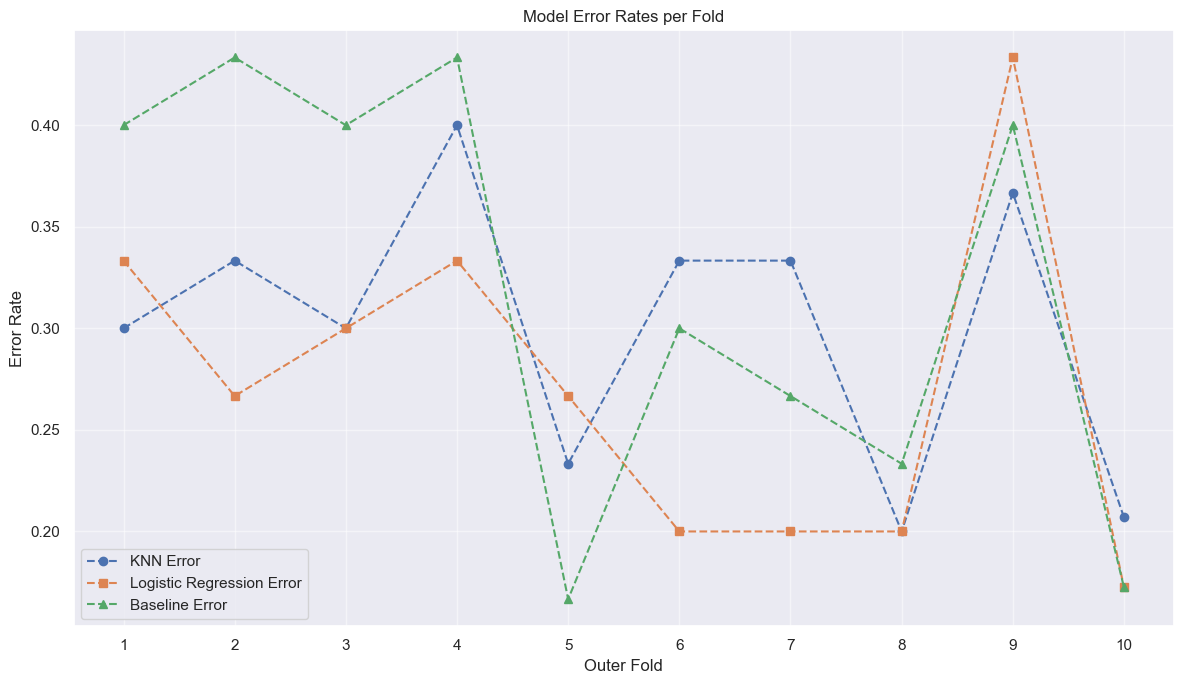

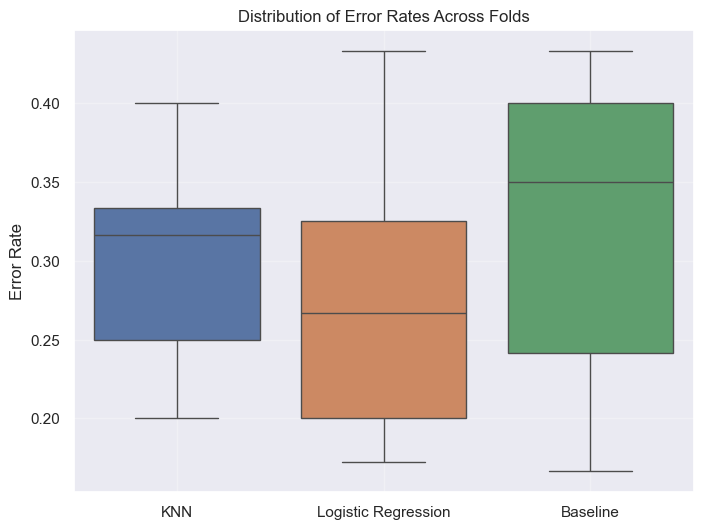

In [ ]:
# Display the results table
print("Results from Nested Cross-Validation:")
display(results_df)

# --- Visualize Error Rates ---
plt.figure(figsize=(12, 7))

# Plot error rates per fold
plt.plot(results_df['Outer Fold'], results_df['KNN Error'], marker='o', linestyle='--', label='KNN Error')
plt.plot(results_df['Outer Fold'], results_df['LogReg Error'], marker='s', linestyle='--', label='Logistic Regression Error')
plt.plot(results_df['Outer Fold'], results_df['Baseline Error'], marker='^', linestyle='--', label='Baseline Error')

plt.title('Model Error Rates per Fold')
plt.xlabel('Outer Fold')
plt.ylabel('Error Rate')
plt.xticks(results_df['Outer Fold'])
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- Boxplot of Error Rates ---
plt.figure(figsize=(8, 6))
error_df = pd.DataFrame({
    'KNN': results_df['KNN Error'],
    'Logistic Regression': results_df['LogReg Error'],
    'Baseline': results_df['Baseline Error']
})
sns.boxplot(data=error_df)
plt.title('Distribution of Error Rates Across Folds')
plt.ylabel('Error Rate')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Calculate the mean error for each model across all folds
mean_knn_error = results_df['KNN Error'].mean()
mean_logreg_error = results_df['LogReg Error'].mean()
mean_baseline_error = results_df['Baseline Error'].mean()

print("--- Average Test Errors from Nested Cross-Validation ---")
print(f"Average KNN Error: {mean_knn_error:.4f}")
print(f"Average Logistic Regression Error: {mean_logreg_error:.4f}")
print(f"Average Baseline Error: {mean_baseline_error:.4f}")

--- Average Test Errors from Nested Cross-Validation ---
Average KNN Error: 0.3007
Average Logistic Regression Error: 0.2706
Average Baseline Error: 0.3206


### 4. Statistical evaluation ucing McNemar's test
McNemar's test is described in the lecture notes, section 11.3.3 and/or method 11.3.2

To perform this test, we will perform K-fold cross-validation again, but this time only using the optimal parameters for the models, which we found earlier by doing two-level CV.

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import scipy.stats as st

# Cross validation folds for McNemar's test
cv_folds = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialise lists to store predictions
contingency_baselineVSknn = np.zeros((2, 2), dtype=int)
contingency_baselineVSlogreg = np.zeros((2, 2), dtype=int)
contingency_knnVSlogreg = np.zeros((2, 2), dtype=int)

# Helper function to create contingency table
def contingency_table(y_true, y_pred1, y_pred2):
    both_correct = np.sum((y_pred1 == y_true) & (y_pred2 == y_true))
    model1_correct_model2_wrong = np.sum((y_pred1 == y_true) & (y_pred2 != y_true))
    model1_wrong_model2_correct = np.sum((y_pred1 != y_true) & (y_pred2 == y_true))
    both_wrong = np.sum((y_pred1 != y_true) & (y_pred2 != y_true))
    return np.array([[both_correct, model1_correct_model2_wrong],
            [model1_wrong_model2_correct, both_wrong]])

# Cross-validation loop for McNemar's test
for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 'train' baseline model
    mcnemar_majority_class = np.argmax(np.bincount(y_train))
    mcnemar_y_pred_baseline = np.full_like(y_test, mcnemar_majority_class)

    # Train KNN with best k
    mcnemar_knn_model = KNeighborsClassifier(n_neighbors=best_k_overall, metric='minkowski', p=1)
    mcnemar_knn_model.fit(X_train, y_train)
    mcnemar_y_pred_knn = mcnemar_knn_model.predict(X_test)

    # Train Logistic Regression with best C
    mcnemar_logreg_model = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
    mcnemar_logreg_model.fit(X_train, y_train)
    mcnemar_y_pred_logreg = mcnemar_logreg_model.predict(X_test)

    # Create contingency table and accumulate
    contingency_baselineVSknn    = contingency_baselineVSknn    + contingency_table(y_test, mcnemar_y_pred_baseline, mcnemar_y_pred_knn)
    contingency_baselineVSlogreg = contingency_baselineVSlogreg + contingency_table(y_test, mcnemar_y_pred_baseline, mcnemar_y_pred_logreg)
    contingency_knnVSlogreg      = contingency_knnVSlogreg      + contingency_table(y_test, mcnemar_y_pred_knn, mcnemar_y_pred_logreg)

mcnemar_theta_hat_baselineVSknn    = (contingency_baselineVSknn[0,1]    - contingency_baselineVSknn[1,0])    / np.sum(contingency_baselineVSknn)
mcnemar_theta_hat_baselineVSlogreg = (contingency_baselineVSlogreg[0,1] - contingency_baselineVSlogreg[1,0]) / np.sum(contingency_baselineVSlogreg)
mcnemar_theta_hat_knnVSlogreg      = (contingency_knnVSlogreg[0,1]      - contingency_knnVSlogreg[1,0])      / np.sum(contingency_knnVSlogreg)

print("--- McNemar's Test Results ---")
for name, table, theta_hat in [
    ("Baseline vs KNN", contingency_baselineVSknn, mcnemar_theta_hat_baselineVSknn),
    ("Baseline vs LogReg", contingency_baselineVSlogreg, mcnemar_theta_hat_baselineVSlogreg),
    ("KNN vs LogReg", contingency_knnVSlogreg, mcnemar_theta_hat_knnVSlogreg)
]:
    result = mcnemar(table, exact=True) # This one gives the same results as in the lecture notes and exercise.

    # No idea whether or not the following is correct. Look into method 11.3.2 in the lecture notes.
    n = np.sum(table) # Total number of samples
    n12 = table[0,1]
    n21 = table[1,0]
    alpha = 0.05 # 95% confidence interval
    Q = (   n**2 
            * (n+1)
            * (theta_hat+1)
            * (1-theta_hat) 
            / ( n * (n12 + n21) - (n12 - n21) ** 2 )) # Eq. 11.33d
    f = (theta_hat + 1)/2 * (Q - 1) # Eq. 11.33b
    g = (1 - theta_hat)/2 * (Q - 1) # Eq. 11.33c
    theta_low = 2 * st.beta.ppf(alpha / 2, f, g) - 1 # Eq. 11.35a
    theta_upp = 2* st.beta.ppf(1 - alpha / 2, f, g) - 1  # Eq. 11.35b
    pvalue = 2 * st.binom.cdf( min([n12, n21]), p=1/2, n=n12+n21) # Eq. 11.36

    print(f"Theta_hat: {theta_hat:.4f}")
    print(f"95% CI for Theta: [{theta_low:.4f}, {theta_upp:.4f}]")
    print(f"P-value: {pvalue:.4f} according to lecture notes method 11.3.2")
    print(f"{name}: p={result.pvalue:.4f}, statistic={result.statistic}, according to statsmodels.stats.contingency_tables.mcnemar")
    print(f"Contingency Table:\n{table}\n")
    


--- McNemar's Test Results ---
Theta_hat: -0.0167
95% CI for Theta: [-0.0565, 0.0230]
P-value: 0.5114 according to lecture notes method 11.3.2
Baseline vs KNN: p=0.5114, statistic=16.0, according to statsmodels.stats.contingency_tables.mcnemar
Contingency Table:
[[187  16]
 [ 21  75]]

Theta_hat: -0.0602
95% CI for Theta: [-0.1190, -0.0012]
P-value: 0.0598 according to lecture notes method 11.3.2
Baseline vs LogReg: p=0.0598, statistic=32.0, according to statsmodels.stats.contingency_tables.mcnemar
Contingency Table:
[[171  32]
 [ 50  46]]

Theta_hat: -0.0435
95% CI for Theta: [-0.0934, 0.0066]
P-value: 0.1175 according to lecture notes method 11.3.2
KNN vs LogReg: p=0.1175, statistic=23.0, according to statsmodels.stats.contingency_tables.mcnemar
Contingency Table:
[[185  23]
 [ 36  55]]



### 5. What does the logistic regression actually do?
For completeness (although we already did this), we will train a logistic regression model and discuss the results.

In [ ]:
# --- FROM PREVIOUS SECTION ---
# Train a new Logistic Regression model on the entire dataset using the overall best C
logreg_model = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
logreg_model.fit(X, y)
print(f"Final Logistic Regression model with C={best_C_overall} (lambda={1/best_C_overall}) has been trained on the entire dataset.")
y_pred_logreg = logreg_model.predict(X)
logreg_accuracy = accuracy_score(y, y_pred_logreg)
print(f"Logistic Regression model training accuracy: {logreg_accuracy:.4f}")
# --- FROM PREVIOUS SECTION ---

print("-" * 50)
print(logreg_model.coef_)
print("-" * 50)

# Print coefficents of model together with feature names
feature_names= X_transformed.columns
for feature, coef in zip(feature_names, logreg_model.coef_[0]):
    print(f"Feature: {str.center(feature,len(max(feature_names, key=len)))}, Coefficient: {coef:.6e}")

Final Logistic Regression model with C=0.0001 (lambda=10000.0) has been trained on the entire dataset.
Logistic Regression model training accuracy: 0.7525
--------------------------------------------------
[[ 3.50564636e-03  9.17529359e-04  4.50272173e-04 -2.59026557e-05
  -3.71472784e-03  1.10171404e-03 -8.18800242e-04 -4.99661324e-03
  -2.68970505e-03 -6.65986205e-05 -1.73993396e-04]]
--------------------------------------------------
Feature:           age           , Coefficient: 3.505646e-03
Feature:         anaemia         , Coefficient: 9.175294e-04
Feature: creatinine_phosphokinase, Coefficient: 4.502722e-04
Feature:         diabetes        , Coefficient: -2.590266e-05
Feature:    ejection_fraction    , Coefficient: -3.714728e-03
Feature:   high_blood_pressure   , Coefficient: 1.101714e-03
Feature:        platelets        , Coefficient: -8.188002e-04
Feature:     serum_creatinine    , Coefficient: -4.996613e-03
Feature:       serum_sodium      , Coefficient: -2.689705e-03
Featu

In [11]:
# Self-contained: pick C by 10-fold CV, remove outliers (IQR), retrain LogisticRegression and report (robust to ndarray vs DataFrame)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


X_df = pd.DataFrame(X)

# Outlier removal via IQR (1.5 * IQR) computed on DataFrame X_df
Q1 = X_df.quantile(0.25)
Q3 = X_df.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
mask = ((X_df >= lower) & (X_df <= upper)).all(axis=1)
n_before = X_df.shape[0]
n_after = int(mask.sum())
print(f"Removed {n_before - n_after} outliers ({(n_before - n_after)/n_before:.1%}). Remaining samples: {n_after}.")

X_clean = X_df.loc[mask].reset_index(drop=True)
# ensure y is a Series aligned with original rows, then select the mask
y_series = pd.Series(np.asarray(y), name='DEATH_EVENT')
y_clean = y_series[mask].reset_index(drop=True)

scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_clean)

results_clean = nested_cv_compare(X_scaled_clean, y_clean,
                                 outer_n_splits=10, inner_n_splits=10)
best_C_overall_cleaned = results_clean[0]['Best C'].values[0]
print(f"Nested CV on cleaned data with fixed C={best_C_overall_cleaned}:")

lr_clean = LogisticRegression(penalty="l2", C=best_C_overall_cleaned, solver="liblinear", max_iter=2000)
lr_clean.fit(X_scaled_clean, y_clean)
y_pred_train = lr_clean.predict(X_scaled_clean)
train_acc = accuracy_score(y_clean, y_pred_train)
print(f"Training accuracy on cleaned data: {train_acc:.4f} (n={n_after})")


Removed 27 outliers (9.0%). Remaining samples: 272.
Nested CV on cleaned data with fixed C=0.0001:
Training accuracy on cleaned data: 0.7500 (n=272)


In [21]:
# Train a model with only the top 2 most important features
feature_importance = np.abs(logreg_model.coef_[0])
top_2_indices = np.argsort(feature_importance)[-2:]
top_2_features = X_transformed.columns[top_2_indices]
print(f"Top 2 features: {top_2_features.tolist()}")
X_top2 = X_transformed[top_2_features]
X_top2_scaled = scaler.fit_transform(X_top2)

# use cross-validation to estimate generalisation accuracy with only top 2 features
cv_folds = KFold(n_splits=30, shuffle=True, random_state=42)
y_pred_top2_all, y_true = [], []
for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
    X_train, X_test = X_top2_scaled[train_idx], X_top2_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    logreg_top2 = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
    logreg_top2.fit(X_train, y_train)
    y_pred_top2 = logreg_top2.predict(X_test)
    y_pred_top2_all.extend(y_pred_top2.tolist())
    y_true.extend(y_test.tolist())
top2_accuracy = accuracy_score(y_true, y_pred_top2_all)

# Training error using not using CV with top 2 features
logreg_top2 = LogisticRegression(penalty='l2', C=best_C_overall, solver='liblinear', max_iter=1000)
logreg_top2.fit(X_top2_scaled, y)
y_pred_top2 = logreg_top2.predict(X_top2_scaled)
top2_accuracy = accuracy_score(y, y_pred_top2)
print(f"Logistic Regression with top 2 features training accuracy: {top2_accuracy:.4f}")

Top 2 features: ['ejection_fraction', 'serum_creatinine']
Logistic Regression with top 2 features training accuracy: 0.7726
